<a href="https://colab.research.google.com/github/Kata5/DeepLearning2021/blob/main/DeepLearning2021_Milestone01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Overview

Welcome to the assignment notebook of Sándor Gregus (YRVTLZ), Katalin Ócsai (EW9A0Z) and Mátyás Prechl (JR4JDJ)!

We decided to work on a larger and simpler database: CelebA.

We have reviewed not only the recommended GAN literature (https://paperswithcode.com/paper/progressive-growing-of-gans-for-improved )
but also VAEs and beta VAEs.




* Chosen topic:

*Cél:  Az arckép jellemzőinek a felismerése. Első lépésben címkézett adatok alapján az adatbázisban található címkékre készítsetek minél jobb modellt. További opcionális lépésként VAE (és/vagy GAN) alapú architektúrával célszerű kísérletezni, hogy a látens változók milyen arc jellemzőket tanulnak meg - akár felismerés, akár generálás idején.* 

*Előny: könnyű nagy mennyiségű adatot beszerezni; de mégis a jó minőségű képek szintéziséhez sok trükk kell*

*Kiindulás: https://paperswithcode.com/paper/progressive-growing-of-gans-for-improved* 

*Adatbázis: https://github.com/dchen236/FairFace, de mást is lehet használni*



*   *Tasks*: 

*   *Adatok beszerzése, adatfeltárás, vizualizáció (ha szükséges) és előkészítés tanításhoz*
*   *Eredmény: tanító, validációs és teszt adatbázisok*

# Download data



Easier access to CelebA database from our own Google Drive.
Unzipping more than 200k files from the zip takes less than a minute.

In [1]:
!mkdir celebA

In [2]:
%cd celebA

/content/celebA


In [3]:
!gdown --id 1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW

Downloading...
From: https://drive.google.com/uc?id=1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW
To: /content/celebA/img_align_celeba.zip
100% 1.44G/1.44G [00:19<00:00, 73.2MB/s]


In [4]:
!gdown --id 1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3

Downloading...
From: https://drive.google.com/uc?id=1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3
To: /content/celebA/list_attr_celeba.csv
100% 24.9M/24.9M [00:00<00:00, 152MB/s]


In [6]:
!unzip -q img_align_celeba.zip

# Get the attributes and do some exploration of the data



*   We checked whether the table of attributes contains empty values
*   We checked whether the table of attributes contains only binary values
*   We checked whether the image database contains (quasi)constant images
*   We checked whether the size of image database matches the size of attribute table



To check the data and attributes we decided to use pandas package.
We imported the table of attributes and had a quick sanity check.

In [7]:
import pandas as pd

In [15]:
# import the data that includes the attributes for each picture
df_attr = pd.read_csv('list_attr_celeba.csv', sep=';')
df_attr.replace(to_replace=-1, value=0, inplace=True) # replace -1 by 0
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


Check for empty / null values in the table.

In [9]:
import numpy as np
np.where(pd.isnull(df_attr))

(array([], dtype=int64), array([], dtype=int64))

Check the different values for each binary attribute. 
We found that all of them were 2 (as it should be).

In [10]:
df2 = pd.DataFrame(df_attr)
df2.nunique()

image_id               202599
5_o_Clock_Shadow            2
Arched_Eyebrows             2
Attractive                  2
Bags_Under_Eyes             2
Bald                        2
Bangs                       2
Big_Lips                    2
Big_Nose                    2
Black_Hair                  2
Blond_Hair                  2
Blurry                      2
Brown_Hair                  2
Bushy_Eyebrows              2
Chubby                      2
Double_Chin                 2
Eyeglasses                  2
Goatee                      2
Gray_Hair                   2
Heavy_Makeup                2
High_Cheekbones             2
Male                        2
Mouth_Slightly_Open         2
Mustache                    2
Narrow_Eyes                 2
No_Beard                    2
Oval_Face                   2
Pale_Skin                   2
Pointy_Nose                 2
Receding_Hairline           2
Rosy_Cheeks                 2
Sideburns                   2
Smiling                     2
Straight_H

Check the number of rows, which must be the same as the number of images (as we saw 202599).

In [11]:
df_attr.shape

(202599, 41)

In [12]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [13]:
import random
import os

crsPath = 'img_align_celeba'

,Wearing_Earrings,Smiling,Mustache,Chubby
101920,0,0,0,0


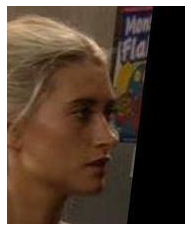

In [14]:
# random example
img_name = random.choice(os.listdir(crsPath))
img = load_img(crsPath + os.sep + img_name)
plt.grid(False)
plt.axis('off')
plt.imshow(img)
# display 4 random attributes
df_attr.loc[df_attr['image_id'] == img_name][random.sample(list(df_attr.columns), len(df_attr.columns))[:4]]

# Split the dataset into train/test/val data

To split the dataset we used random permutation of the data in the ratio of 0.8 : 0.1 : 0.1
Then we checked the distribution of the different attributes across the train/test/val datasets.

In [16]:
import csv

# setup ratio (val ratio = rest of the files in origin dir after splitting into train and test)
train_ratio = 0.8
test_ratio = 0.1


# total count of imgs
totalImgCount = len(os.listdir(crsPath))
print("total img count:", totalImgCount)
countForTrain = int(totalImgCount*train_ratio)
countForTest = int(totalImgCount*test_ratio)
countForValid = totalImgCount - countForTrain - countForTest

print("train count:", countForTrain)
print("test count:", countForTest)
print("val count:", countForValid)
randPermute = np.random.permutation(totalImgCount)

with open('list_eval_partition.csv','w') as f:
    writer = csv.writer(f)

    # cycle for train dir
    for x in range(countForTrain):
        counter = randPermute[x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','0'])

    # cycle for test dir
    for x in range(countForTest):
        counter = randPermute[countForTrain + x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','1'])    

    # cycle for valid  dir
    for x in range(countForValid):
        counter = randPermute[countForTrain + countForTest + x]
        writer.writerow(['{:06}'.format(counter+1)+'.jpg','2'])

total img count: 202599
train count: 162079
test count: 20259
val count: 20261


In [17]:
df_split = pd.read_csv('list_eval_partition.csv', names=['image_id', 'split'])

In [18]:
df_buff = df_attr.merge(df_split, on=["image_id"])
df_buff = df_buff.sort_index()
df_buff.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,split
0,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,2
3,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [19]:
df_train = df_buff[df_buff['split'] == 0]
df_test = df_buff[df_buff['split'] == 1]
df_val = df_buff[df_buff['split'] == 2]

In [20]:
train_attr_perc = df_train.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)
test_attr_perc = df_test.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)
val_attr_perc = df_val.drop(columns=['split', 'image_id']).apply(pd.value_counts, normalize=True).drop(0)

In [21]:
print(test_attr_perc)

   5_o_Clock_Shadow  Arched_Eyebrows  ...  Wearing_Necktie     Young
1          0.110618          0.26793  ...         0.070734  0.777087

[1 rows x 40 columns]


In [22]:
df_plot = train_attr_perc.transpose().join(test_attr_perc.transpose(), lsuffix='train', rsuffix='test').join(val_attr_perc.transpose())
df_plot.columns = ['train', 'test', 'val']
df_plot.head()

,train,test,val
5_o_Clock_Shadow,0.111020,0.110618,0.112581
Arched_Eyebrows,0.266839,0.267930,0.267164
Attractive,0.511979,0.513648,0.515572
Bags_Under_Eyes,0.204400,0.206427,0.204087
Bald,0.022501,0.021373,0.023049


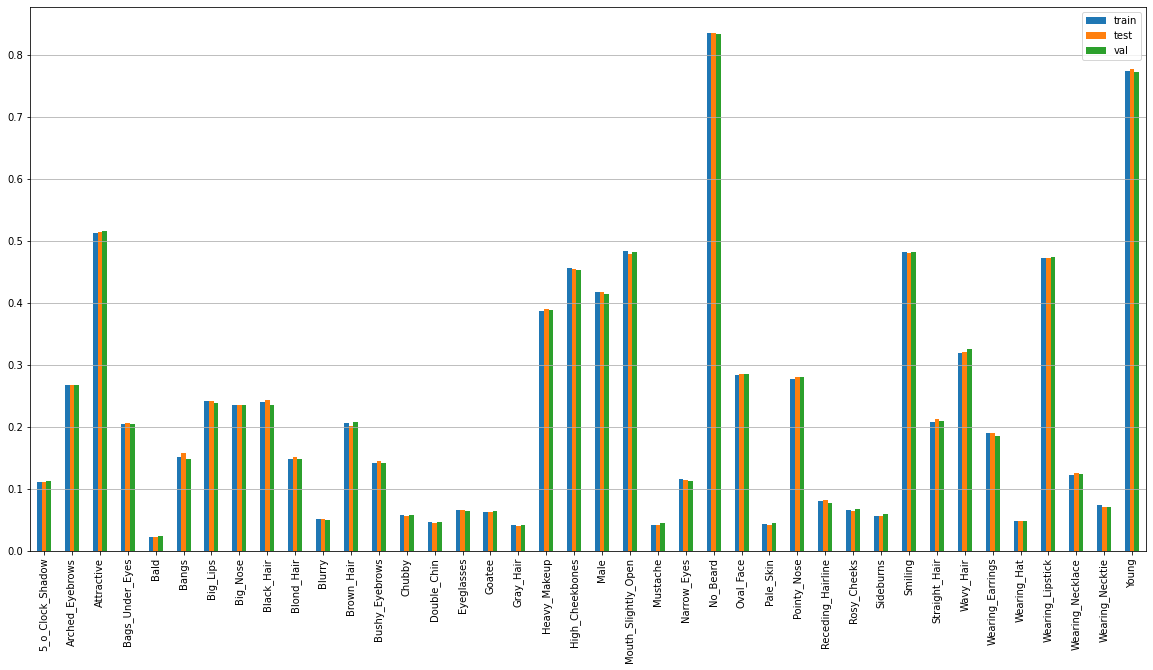

In [23]:
df_plot.plot(kind='bar', figsize=(20,10)).grid(axis='y')

The plot shows an even distribution of the attributes across the train/test/val datasets.

# Preprocessing of the data
Before normalizing the images we checked the standard deviation of the red, green and blue channels so as to avoid division by a very small number (and using quasi-constant images).

In [24]:
# set variables
EXAMPLE_PIC = crsPath + os.sep + img_name

EPSILON = 0.001 # for checking the std of images
TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20


In [25]:
from skimage import io
import glob

files = []
ext = ['jpg']
[files.extend(glob.glob(crsPath + '/*.' + e)) for e in ext]

# channels for RGB images
channels = ['RED', 'GREEN', 'BLUE']
i = 0
with open('MeanStdPerChannels.csv','w') as f:
  writer = csv.writer(f)
  for file in files: # iteration on files in the folder
    image = io.imread(file)
    stdr = np.std(image[:, :, 0])
    stdg = np.std(image[:, :, 1])
    stdb = np.std(image[:, :, 2])
    fn = os.path.basename(file)
    if stdr<EPSILON or stdg<EPSILON or stdb<EPSILON:
      print(fn)
      writer.writerow([fn, stdr, stdg, stdb])

We use ImageDataGenerator from tensorflow for data augmentation

In [29]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array

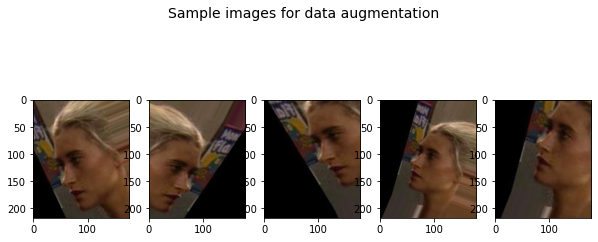

In [30]:
datagen =  ImageDataGenerator(
  horizontal_flip=True,
  rotation_range=30,
  zoom_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  width_shift_range=0.2
)

# load one image and reshape
img = load_img(crsPath + os.sep + img_name)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 5 augmented images of the loaded image
plt.figure(figsize=(10,10))
plt.suptitle('Sample images for data augmentation', fontsize=14)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 4:
        break
    i += 1
    
plt.show()

## Data Augmentation with rotation, shifting, shearing, zooming,

We decided to try to augment training and validation set with the ImageDataGenerator function

In [32]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
# partition 0 - train;  1 -validation;  2 - test
    
    df_ = df_attr[(df_attr['split'] == partition) 
                           & (df_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_attr[(df_attr['split'] == partition) 
                                  & (df_attr[attr] == 1)].sample(int(num_samples/2))])

    print(df_.index)
    # for Train and Validation
    print((images_folder))
    if partition != 2:
        x_ = np.array([load_reshape_img(imdir +'/'+ fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

In [33]:
# Train data
x_train, y_train = generate_df(0, 'Male', 1000)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)


KeyError: ignored

In [ ]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)


# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)


Index(['050746.jpg', '089895.jpg', '146748.jpg', '162564.jpg', '160235.jpg',
       '136052.jpg', '084825.jpg', '003339.jpg', '147947.jpg', '067349.jpg',
       ...
       '152588.jpg', '129578.jpg', '136942.jpg', '181123.jpg', '012436.jpg',
       '142185.jpg', '104484.jpg', '024681.jpg', '187717.jpg', '100187.jpg'],
      dtype='object', name='image_id', length=2000)
../input/celebA/img_align_celeba/
